# Comparing peptigate predictions from RNA-seq data SRP074404 against paired mass spec peptidomics data

One way to validate the peptigate peptide predictions is to compare them against mass spectrometry peptidomics data.
Peptidomics is a specific mass spec technique that targets small protein sequences.
We identified a study where both transcriptomics and peptidomics were undertaken: ["A gene family coding for salivary proteins (SHOT) of polyphagous spider mite *Tetranychus urticae* exhibits fast host-dependent transcriptional plasticity"](https://doi.org/10.1094/MPMI-06-17-0139-R).
This notebook compares the peptides predicted in the mass spec data vs. those predicted by peptigate.

## Background on data

### Peptidomics data set (paraphrased methods from paper, some direct quoting)

Researchers collected mites from host plants including beans (Phaseolus vulgaris), soybeans (G. max), and tomatoes (S. lycopersicum). The mites were placed on a synthetic diet wrapped in parafilm for 24 hours to feed. After this period, the diet remnants, now mixed with the mites' saliva, were gathered and preserved at −80°C. Once enough material was amassed (about 0.3 ml per sample), it underwent a nano-LC-MS/MS analysis to identify the proteins within the saliva. The saliva-enriched diet underwent filtration using a specific spin-down filter to separate the saliva peptides. These peptides were then purified through solid-phase extraction using a specialized column. The resulting eluate was dried and stored at −80°C until it was ready for mass spec (nano-LC-MS/MS).

Peak lists obtained from MS/MS spectra were identified using OMSSA, X!Tandem version X! Tandem Vengeance, and MS-GF+. Protein identification was conducted against a concatenated target/decoy version of the *T. urticae* protein database holding 19,086 *T. urticae* target sequences (version of August 11, 2016, available at OrcAE) and the common cRAP database (116 sequences). Peptide spectrum matches were inferred from the spectrum identification results using PeptideShaker with a 1.0% false discovery rate (FDR) estimated using the decoy hit distribution. The results are in the ProteomeXchange Consortium via the PRIDE partner repository (PXD006385).

**Note about peptidomics data**: I think the amino acid sequences reported are full-length proteins for which there were peptide hits in the mass spec data, even though the peptides in the MS data would have been shorter (probably).

### RNA-seq data
The paired transcriptome data came from *T. urticae* proterosomas containing the salivary glands and intact females in a publication by the same first author as the one cited above.
The data are available on the Sequence Read Archive under accession SRP074404.
We re-analyzed the transcriptome using reads2transcriptome to generate a *de novo* transcriptome.

## Summary of relevant study findings

* 279 peptides were identified, of which 216, 116, and 133 were found in the Phaseolus vulgaris, G. max and S. lycopersicum samples, respectively.

## Thoughts

* Over prediction of sORFs from fragmented transcripts.
    * potential filtering step --> For sORFs only, if there is an annotated genome, BLAST the "peptide" prediction against those genes. Also BLAST the transcript. If the transcript is a fragment of the gene and has a hit to a protein, then it's probably a fragment that should not be included.

## Notebook setup

In [1]:
library(tidyverse, warn.conflicts = F)
library(ggExtra)
library(umap)
library(Rtsne)

── Attaching core tidyverse packages ────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
# adjust plot size rendered inline
options(repr.plot.width = 5, repr.plot.height = 3, repr.plot.res = 300)

## The transcriptome we assembled is very low quality

BUSCO is usually run at the end of `reads2transcriptome` (the assembly pipeline we used to assemble this transcriptome).
However, because of a bug, it was not this time.
We ran BUSCO at https://gvolante.riken.jp/results.html using Busco V5 against the Arthropoda database.

#### Completeness Assessment Results:

| Metric | Value |
| ------------------------|------------------------------- |
| Total number of core genes queried                      | 1013 |
| Number of core genes detected                           | |
| .. Complete                                              | 9 (0.89%) |
| .. Complete + Partial                                    | 11 (1.09%) |
| Number of missing core genes                            | 1002 (98.91%) |
| Average number of orthologs per core genes              | 1.33 |
| % of detected core genes that have more than 1 ortholog | 22.22 |
| Scores in BUSCO format                                  | C:0.9% (S:0.7%,D:0.2%),F:0.2%,M:98.9% |

#### Length Statistics and Composition:

| Metric | Value |
| ------------------------|------------------------------- |
| Number of sequences                                     | 8634 |
| Total length (nt)                                       | 2115051 |
| Longest sequence (nt)                                   | 12729 |
| Shortest sequence (nt)                                  | 106 |
| Mean sequence length (nt)                               | 245 |
| Median sequence length (nt)                             | 161 |
| N50 sequence length (nt)                                | 178 |
| L50 sequence count                                      | 1863 |
| Number of sequences > 1K (nt)                           | 181 (2.1% of total number) |
| Number of sequences > 10K (nt)                          | 1 (0.0% of total number) |
| Number of sequences > 100K (nt)                         | 0 (0.0% of total number) |
| Number of sequences > 1M (nt)                           | 0 (0.0% of total number) |
| Number of sequences > 10M (nt)                          | 0 (0.0% of total number) |
| Number of gaps (>=5 N's)                                |  |
| GC-content (%)                                          | 42.91 |
| Number of non-ACGTN (nt)                                | 0 |


These numbers are abysmal.
The transcriptome is very incomplete (missing 98% of genes we expect to see) and very fragmented.
**Even still, let's see how we do with this very low quality data.**

## First, let's investigate how many (parent) peptide sequences ended up in our very bad transcriptome assembly

If a parent peptide isn't in the assembly, we won't be able to detect the peptide.
A few hundred parent peptides made it into the transcriptome assembly, depending on how we threshold.

In [3]:
peptidomics_tblastn <- read_tsv("tblastn/peptidomics_vs_transcriptome_tblastn.tsv.gz",
                                col_names = c("qseqid", "qlen", "qseq", "sseqid", 
                                              "slen", "sseq", "pident", 
                                              "length", "mismatch", "gapopen", 
                                              "qstart", "qend", "sstart", "send",
                                              "evalue", "bitscore"),
                               show_col_types = F) %>%
  # grab just the top hit for each query
  group_by(qseqid) %>%
  slice_max(bitscore, n = 1) %>%
  slice_min(evalue, n = 1) %>%
  # if nothing differentiates the matches, just pick one
  slice_head(n = 1) %>%
  ungroup()

nrow(peptidomics_tblastn)
length(unique(peptidomics_tblastn$qseqid))

[1] 18427

[1] 18427

In [4]:
probably_real_matches <- peptidomics_tblastn %>%
  mutate(qcov = length / qlen,
         scov = length /slen) %>%
  filter(qcov > 0.3 | scov > 0.3) %>%
  filter(pident > 80) %>%
  filter(length > min(qlen)) %>%
  arrange(desc(pident)) %>%
  select(qseqid, qlen, slen, length, pident, bitscore, qcov, scov)
nrow(probably_real_matches)

[1] 381

In [5]:
peptidomics_tblastn <- peptidomics_tblastn %>%
  mutate(probably_real_match = ifelse(qseqid %in% probably_real_matches$qseqid, "probably real", "probably not real"))

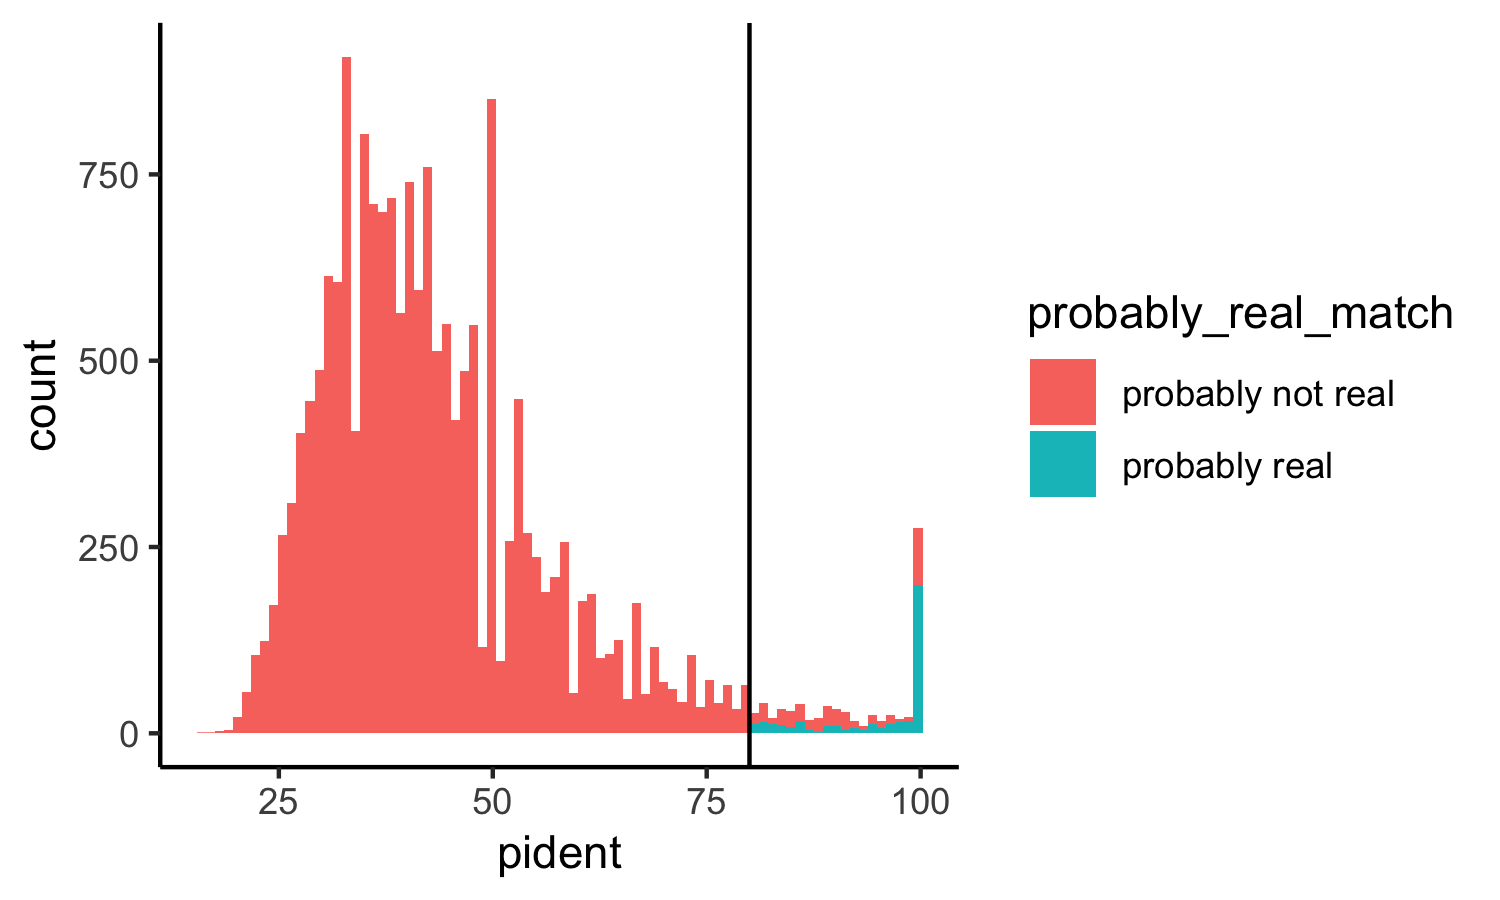

In [6]:
ggplot(peptidomics_tblastn, aes(x = pident, fill = probably_real_match)) +
  geom_histogram(bins = 80) +
  theme_classic() +
  geom_vline(xintercept = 80, color = "black")

## Next, let's see how many peptides specifically mentioned in the paper made it into the transcriptome assembly

In [7]:
proteinase_inhibitors <- c("tetur22g00290", "tetur40g00392", "tetur95g00060", "tetur95g00080")
serine_proteases <- c("tetur12g03940", "tetur12g03950", "tetur30g01440", "tetur66g00060", "tetur66g00070")
armadillo_folds <- c("tetur31g00630", "tetur49g00080")
fifty_percent_mapped <- c("tetur29g01360", "tetur07g00160", "tetur07g01660")
slyco_mapped <- c("tetur22g00290", "tetur30g01440", "tetur31g00830", "tetur49g00080")
shot_mapped <- c("tetur03g03620", "tetur03g03670", "tetur03g03680", "tetur03g03690", 
                 "tetur03g03700", "tetur03g03730", "tetur03g10083", "tetur03g10093", 
                 "tetur11g01360", "tetur11g06390", "tetur11g06400")
all <- c(proteinase_inhibitors, serine_proteases, armadillo_folds, fifty_percent_mapped,
         slyco_mapped, shot_mapped, "tetur18g00530")

In [8]:
table(grepl(pattern = paste(all, collapse = "|"), x = probably_real_matches$qseqid))


FALSE  TRUE 
  380     1 

In [9]:
length(all)

[1] 30

In [10]:
peptidomics_tblastn[grepl(pattern = paste(all, collapse = "|"), x = peptidomics_tblastn$qseqid), ] %>%
  select(qseqid, pident, qlen, slen, length, bitscore) %>%
  arrange(desc(pident))

qseqid,pident,qlen,slen,length,bitscore
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
generic|tetur31g00830,96.721,365,184,61,120.0
generic|tetur07g01660,90.323,1419,153,31,53.1
generic|tetur03g10093,78.947,258,164,19,31.6
generic|tetur29g01360,77.477,526,334,111,105.0
generic|tetur03g03730,77.358,258,164,53,29.3
generic|tetur07g00160,70.000,1799,157,20,29.6
generic|tetur31g00630,64.000,350,266,125,111.0
generic|tetur18g00530,54.545,76,172,11,21.9
generic|tetur11g01360,47.059,322,155,17,24.3


22 of 30 peptide parents discussed in the paper had tBLASTn hits in the transcriptome, but only one looks like it might be a real hit.
Essentially, we won't be able to compare our predictions to those called out in the paper because these sequences are missing from the input transcriptome.

## Now, let's see what our peptigate results look like

### Read in and parse peptigate results

In [12]:
srp_predictions <- read_tsv("../results/SRP074404/peptide_predictions.tsv.gz", show_col_types = F)

srp_annotations <- read_tsv("../results/SRP074404/peptide_annotations.tsv.gz", show_col_types = F) %>%
  mutate(length = nchar(sequence)) %>%
  mutate(length_split = ifelse(length <31, "30 or less", "31 or greater")) %>%
  mutate(peptipedia_blast_result = ifelse(!is.na(peptipedia_blast_bitscore), "blast hit", "no blast hit"))

srp_results <- left_join(srp_predictions, srp_annotations, by = "peptide_id")

print(paste0("Total number of results: ", nrow(srp_results)))
print(paste0("Total distinct peptide names: ", length(unique(srp_results$peptide_id))))
print(paste0("Total distinct peptide sequences: ", length(unique(srp_results$sequence))))


[1] "Total number of results: 3042"
[1] "Total distinct peptide names: 2954"
[1] "Total distinct peptide sequences: 2953"


In [13]:
# filter to distinct sequences
# requires removing metadata columns that might not be the same even if sequences are the same.
srp_results_distinct <- srp_results %>%
  select(-peptide_id, -start, -end, -peptipedia_blast_sseqid, -peptipedia_blast_full_sseq,
         -nlpprecursor_class_score, -nlpprecursor_cleavage_score) %>%
  select(peptide_type, peptide_class, prediction_tool, sequence, AB, ACE, ACP, 
         AF, AMAP, AMP, AOX, APP, AV, BBP, DPPIV, MRSA, Neuro, QS, TOX, TTCA, 
         aliphatic_index, boman_index, charge, hydrophobicity, instability_index, 
         isoelectric_point, molecular_weight, pd1_residue_volume, 
         pd2_hydrophilicity, z1_lipophilicity, z2_steric_bulk_or_polarizability,
         z3_polarity_or_charge, z4_electronegativity_etc, z5_electronegativity_etc, 
         peptipedia_blast_pident, peptipedia_blast_evalue, 
         peptipedia_blast_bitscore, peptipedia_num_hits, peptipedia_blast_result,
         length, length_split) %>%
  distinct()

srp_results_distinct %>%
  group_by(prediction_tool) %>%
  tally() %>%
  arrange(desc(n))

prediction_tool,n
<chr>,<int>
plmutils,2930
deeppeptide,22
nlpprecursor,1


### How many results had BLASTp hits against peptipedia?

If they match against peptipedia, they might be real.

In [14]:
srp_results_distinct %>%
  group_by(prediction_tool, peptipedia_blast_result) %>%
  tally()

prediction_tool,peptipedia_blast_result,n
<chr>,<chr>,<int>
deeppeptide,no blast hit,22
nlpprecursor,no blast hit,1
plmutils,blast hit,12
plmutils,no blast hit,2918


In [15]:
srp_results_distinct %>%
  filter(peptipedia_blast_result == "blast hit") %>%
  select(sequence, peptipedia_blast_pident, peptipedia_blast_evalue, 
         peptipedia_blast_bitscore, peptipedia_num_hits)

sequence,peptipedia_blast_pident,peptipedia_blast_evalue,peptipedia_blast_bitscore,peptipedia_num_hits
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
VRQDPSIMGGIVIQVGDKRIDGSVARRLEELEKSLLRTNSIR,53.6,1.58e-05,38.9,5
LLADEISPDTCRIWDKATNANFDKDVYRNNTGSLIETYQIFLNKLEDLK,100.0,5.80e-08,44.7,4
MDDTSRSIIRNVKGPVKVDDILCLLESEREARRLR,91.4,5.00e-15,62.8,25
MARGNQRELARQKNLKKQAELKKNSGANAKDGNKGLSLEERKFRWVDNFILVIDYLFSIWIIFHPICPLIFIFQRC,57.4,7.76e-09,49.3,2
LPKAHTCFNRIDIPPYESYEKLYEKLLTAIEETCGFAVE,68.0,2.81e-10,50.1,25
LHTTIDTSIGGGLRIRVGDEVIDGTLGARLAAVREKFAKNLK,50.0,5.15e-04,35.0,1
VVFDRGGYLYHGRVKALADSARENGLKF,100.0,3.47e-14,61.6,25
TEIAPAGPFYFAEDYHQQYLEKNPAGYCGLGGTGVACPIGVGVTA,70.0,5.37e-18,70.1,25
MYRYESRNDDNVTKVREFWRNVLNEDEKKTISIKFGREP,59.3,5.52e-04,34.3,2


I quickly BLASTed these sequences against NCBI nr:
* LLADEISPDTCRIWDKATNANFDKDVYRNNTGSLIETYQIFLNKLEDLK	has 100% identity to TPA: phosphoribosylaminoimidazolesuccinocarboxamide synthase Staphylococcus aureus
* LDGATIDFKDTISEQGFTIDNPNAAGSCACGDSFH has 100% identity to iron-sulfur cluster insertion protein ErpA Microbacterium sp. CPCC 204701
* LVDRGHRELPIRADFVGKNIPTSKEETVSVYLEEMDQRNAVIIK has 100% identity to Uracil phosphoribosyltransferase / Pyrimidine operon regulatory protein PyrR Staphylococcus aureus
* VVFDRGGYLYHGRVKALADSARENGLKF has 100% identity to Select seq ref|WP_057990309.1| 	50S ribosomal protein L18 Streptococcus agalactiae
 
I believe these are real predictions, in particular the bacterial ORFs (I think bacterial ORFs are more like to be short than eukaryotic anyway.

This demonstrates that contamination is a real threat in this analysis.
**Whenever interested in following up with one of the peptigate peptide predictions, it should be BLASTed against NR to make sure it is not a bacterial or otherwise cosmopolitan sequence.**

### How many peptigate predictions had BLASTp hits against the peptidomics data set?

In [33]:
peptidomics_blastp <- read_tsv("blastp/peptigate_sequences_vs_peptidomics_blastp.tsv.gz",
                               col_names = c("qseqid", "qlen", "qseq", "sseqid", 
                                             "slen", "sseq", "pident", 
                                             "length", "mismatch", "gapopen", 
                                             "qstart", "qend", "sstart", "send",
                                             "evalue", "bitscore"),
                              show_col_types = F) %>%
  mutate(qcov = length / qlen,
         scov = length /slen) %>%
  # grab just the top hit for each query
  group_by(qseqid) %>%
  slice_max(bitscore, n = 1) %>%
  slice_min(evalue, n = 1) %>%
  # if nothing differentiates the matches, just pick one
  slice_head(n = 1) %>%
  ungroup() %>%
  rename_with(~paste0("blastp_", .))

In [34]:
table(srp_results$peptide_id %in% peptidomics_blastp$blastp_qseqid)


FALSE  TRUE 
  242  2800 

In [35]:
# join to peptigate metadata and re-filter to distinct sequences (one hit per sequence)
# this is verbose and repeats code from above because the distinct data set does not contain the peptide_id to match with
peptidomics_blastp <- right_join(srp_results, peptidomics_blastp, by = c("peptide_id" = "blastp_qseqid")) %>%
  select(peptide_type, peptide_class, prediction_tool, sequence, AB, ACE, ACP, 
         AF, AMAP, AMP, AOX, APP, AV, BBP, DPPIV, MRSA, Neuro, QS, TOX, TTCA, 
         aliphatic_index, boman_index, charge, hydrophobicity, instability_index, 
         isoelectric_point, molecular_weight, pd1_residue_volume, 
         pd2_hydrophilicity, z1_lipophilicity, z2_steric_bulk_or_polarizability,
         z3_polarity_or_charge, z4_electronegativity_etc, z5_electronegativity_etc, 
         peptipedia_blast_pident, peptipedia_blast_evalue, 
         peptipedia_blast_bitscore, peptipedia_num_hits, peptipedia_blast_result,
         length, length_split, starts_with("blastp")) %>%
  distinct()
nrow(peptidomics_blastp)
length(unique(peptidomics_blastp$sequence))

[1] 2724

[1] 2724

In [36]:
# filter to results that are likely actual hits
probably_real_matches_blastp <- peptidomics_blastp %>%
  filter(blastp_qcov > 0.5 | blastp_scov > 0.3) %>%
  filter(blastp_pident > 80) 
  #filter(blastp_length > min(blastp_qlen))

peptidomics_blastp <- peptidomics_blastp %>%
  mutate(probably_real_match = ifelse(sequence %in% probably_real_matches_blastp$sequence, "probably real", "probably not real"))

In [38]:
table(peptidomics_blastp$probably_real_match)


probably not real     probably real 
             2688                36 

In [39]:
peptidomics_blastp %>% 
  group_by(prediction_tool, probably_real_match) %>%
  tally()


peptidomics_blastp %>%
  mutate(evidence_peptide_is_real = ifelse(peptipedia_blast_result == "blast hit" | probably_real_match == "probably real", 
                                           "evidence", 
                                           "no evidence")) %>%
  group_by(prediction_tool, evidence_peptide_is_real) %>%
  tally()

prediction_tool,probably_real_match,n
<chr>,<chr>,<int>
deeppeptide,probably not real,11
deeppeptide,probably real,7
nlpprecursor,probably real,1
plmutils,probably not real,2677
plmutils,probably real,28


prediction_tool,evidence_peptide_is_real,n
<chr>,<chr>,<int>
deeppeptide,evidence,7
deeppeptide,no evidence,11
nlpprecursor,evidence,1
plmutils,evidence,38
plmutils,no evidence,2667


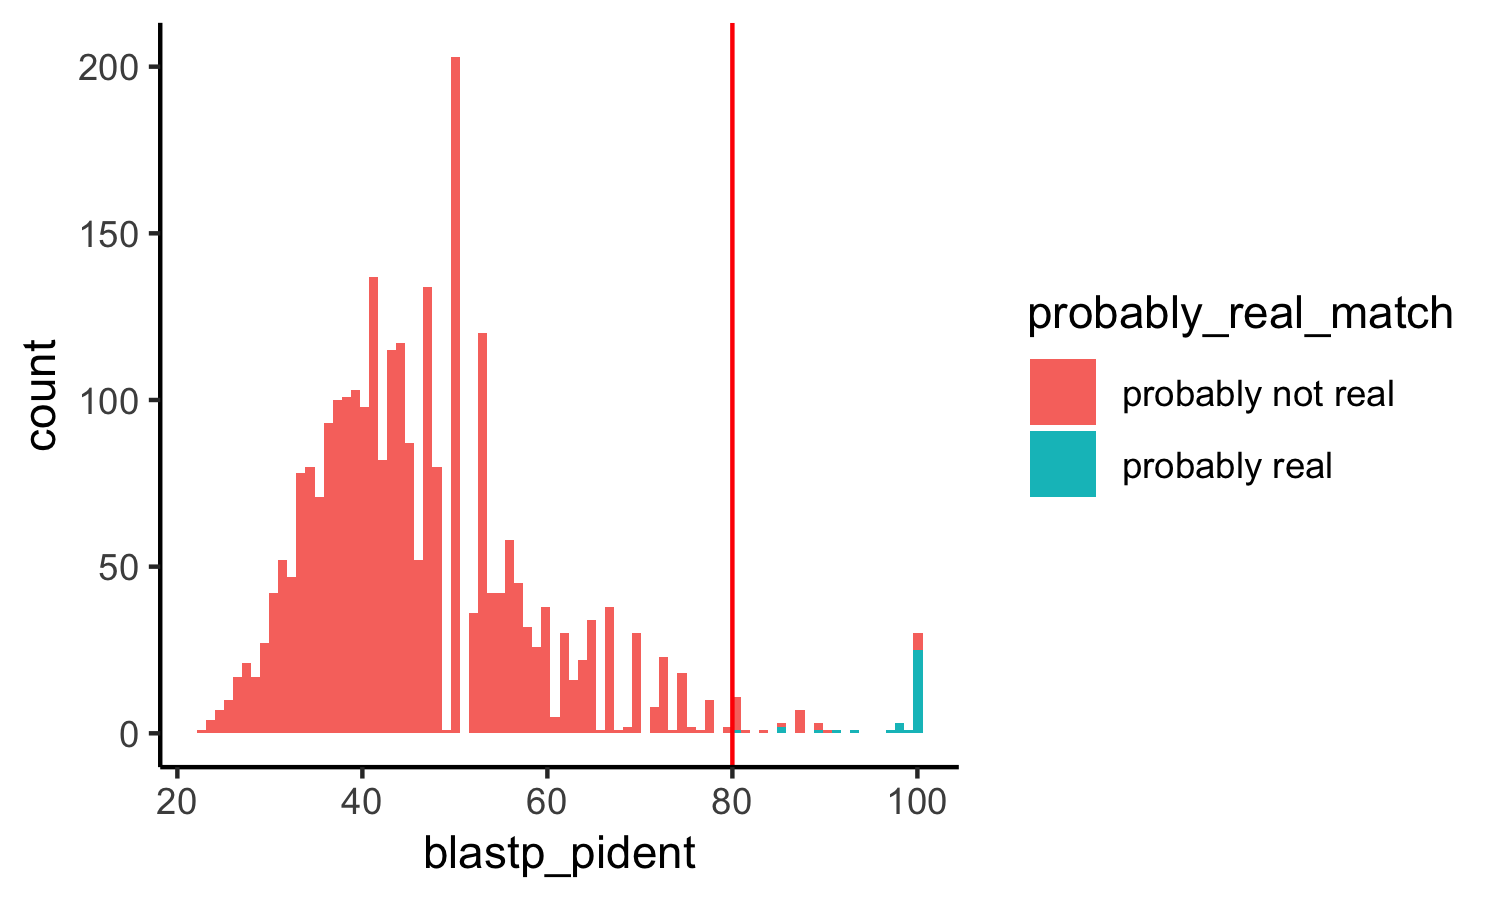

In [40]:
ggplot(peptidomics_blastp, aes(x = blastp_pident, fill = probably_real_match)) +
  geom_histogram(bins = 80) +
  theme_classic() +
  geom_vline(xintercept = 80, color = "red")

In [41]:
peptidomics_blastp %>%
  filter(blastp_pident > 80) %>%
  select(prediction_tool, probably_real_match, blastp_sseqid, blastp_pident, blastp_length, blastp_qlen, blastp_slen, 
          blastp_mismatch, blastp_evalue, blastp_bitscore, blastp_qcov, blastp_scov) %>%
  arrange(desc(probably_real_match), desc(blastp_pident))


prediction_tool,probably_real_match,blastp_sseqid,blastp_pident,blastp_length,blastp_qlen,blastp_slen,blastp_mismatch,blastp_evalue,blastp_bitscore,blastp_qcov,blastp_scov
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
nlpprecursor,probably real,generic|tetur23g00830,100.000,20,20,809,0,6.17e-09,46.6,1.0000000,0.024721879
deeppeptide,probably real,generic|tetur01g05620,100.000,49,49,1293,0,2.16e-26,97.8,1.0000000,0.037896365
deeppeptide,probably real,generic|tetur02g02930,100.000,30,30,522,0,4.38e-14,61.6,1.0000000,0.057471264
deeppeptide,probably real,generic|tetur16g00590,100.000,25,25,92,0,1.19e-11,51.6,1.0000000,0.271739130
deeppeptide,probably real,generic|tetur21g01930,100.000,18,18,159,0,2.17e-07,41.6,1.0000000,0.113207547
deeppeptide,probably real,generic|tetur13g00300,100.000,9,9,569,0,1.60e+00,21.9,1.0000000,0.015817223
deeppeptide,probably real,generic|tetur03g07860,100.000,24,24,234,0,1.38e-10,51.2,1.0000000,0.102564103
deeppeptide,probably real,generic|tetur03g07860,100.000,28,28,234,0,7.10e-14,60.1,1.0000000,0.119658120
plmutils,probably real,generic|tetur09g92921,100.000,51,62,51,0,9.26e-33,105.0,0.8225806,1.000000000


The cleavage peptide prediction tools are doing a good job.
These results suggest to me that deeppeptide and nlpprecursor are robust against fragmentation in the input transcriptome (which makes sense because they operate on gene predictions, which would be a small set of genes for such a fragmented assembly).
However, in all but 1 case, the prediction looks real, which means they are accurate prediction tools (1/1 for nlpprecursor, 1/8 for deeppeptide).

The sORF prediction tool plmutils suffers from rampant over-prediction.
We hypothesized that some of this overprediction might be due to the fragmented nature of the transcriptome -- if true coding transcripts are fragmented, they probably wouldn't be annotated by transdecoder and thus would be scanned for sORFs.
Some of these might be predicted to be in the correct open reading frame but be fragments of the full length protein.
To test this hypothesis, we BLASTed all of the plmutils sORF predictions against a clustered version of the nr database (see details here: https://github.com/Arcadia-Science/peptigate/issues/24).
We found that 4% of plmutils sORF predictions (116 peptides) had hits to proteins >100 amino acids long in the Arcadia clustered nr database.
While this accounts for a small fraction of over prediction of peptides, it does not account for all of it.

We then hypothesized that protein-coding fragmented transcripts translated in the wrong open reading frame leads to over prediction.
If they are in the wrong frame, few sORF peptides would have hits against proteins in databases.
We BLASTx'd the transcripts that lead to sORFs against uniref50 as well as the clustered nr database.
We found that 1239 transcripts had hits against uniref50 (evalue < 1e-10) and 1394 transcripts had hits against clustered nr (evalue < 1e-10).
This shows that fragmented transcripts that are translated in the wrong open reading frame account for at least half of the over prediction we observe by plmutils.
We plan to implement a filter into peptigate so that this source of over prediction is eliminated moving forward.

### Do we predict a peptide from the one transcript tetur31g00830 that was mentioned in the paper and that ended up in the transcriptome assembly?

We do not, meaning we are still missing some peptides.
With this low of numbers, it is difficult to estimate how many we are missing.

In [42]:
peptidomics_blastp %>%
  filter(blastp_pident > 80) %>%
  select(prediction_tool, probably_real_match, blastp_sseqid, blastp_pident, blastp_length, blastp_qlen, blastp_slen, 
          blastp_mismatch, blastp_evalue, blastp_bitscore, blastp_qcov, blastp_scov) %>%
  arrange(desc(probably_real_match), desc(blastp_pident)) %>%
  filter(blastp_sseqid == "tetur31g00830")

prediction_tool,probably_real_match,blastp_sseqid,blastp_pident,blastp_length,blastp_qlen,blastp_slen,blastp_mismatch,blastp_evalue,blastp_bitscore,blastp_qcov,blastp_scov
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


## Conclusions

* The quality of the input transcriptome really matters. We detected only parts of two of the transcripts that were parent proteins to the peptides identified by peptidomics in the study. This means that our transcriptome did not contain the input sequences that would have been necessary to detect the majority of the peptides identified by peptidomics.
    * For this transcriptome, that isn't particularly surprising. There were only four samples that we co-assembled, which isn't a lot to get a complete transcriptome out. R2T didn't finish running, so we don't have busco (completeness) and salmon (percent of reads that map back) estimates.
    * In a pinch, the sORF predictions could be BLASTed against nr or swissprot, and any hit that matches to a larger protein sequence could be filtered out. When we did this against 
* Fragmented transcriptomes will also cause more sORFs to be detected. Not shown here in this notebook, but I BLASTed some of the plmutils sORF predictions against NR and a lot of them hit coding transcripts. This suggests that plmutils is finding real coding fragments but that those fragments are part of longer genes, not true sORFs.
* Contamination in the input transcriptome, particularly bacterial or other species with naturally occurring sORFs, will lead to real sORF predictions but from the wrong species (the contaminant species)
* NLPPrecursor and DeepPeptide had very accurate results with very few false negatives. If they produced a prediction, it appears that that prediction was true.

In [23]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Big Sur ... 10.16

Matrix products: default
BLAS/LAPACK: /Users/taylorreiter/miniconda3/envs/pepeval/lib/libopenblasp-r0.3.26.dylib;  LAPACK version 3.12.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/New_York
tzcode source: internal

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] Rtsne_0.17      umap_0.2.10.0   ggExtra_0.10.0  lubridate_1.9.3
 [5] forcats_1.0.0   stringr_1.5.1   dplyr_1.1.4     purrr_1.0.2    
 [9] readr_2.1.5     tidyr_1.3.1     tibble_3.2.1    ggplot2_3.5.0  
[13] tidyverse_2.0.0

loaded via a namespace (and not attached):
 [1] utf8_1.2.4        generics_0.1.3    lattice_0.22-6    stringi_1.8.3    
 [5] hms_1.1.3         digest_0.6.35     magrittr_2.0.3    evaluate_0.23    
 [9] grid_4.3.3        timechange_0.3.0  pbdZMQ_0.3-11     fastmap_1.1